# Weekly Project: Image Classification with Transfer Learning

In this project, you will build a complete image classification pipeline using transfer learning. You'll work with the dataset provided by your instructor.

**Learning Objectives:**
- Load and prepare image datasets for deep learning
- Use pre-trained models for transfer learning
- Implement two transfer learning strategies: fine-tuning and feature extraction
- Evaluate model performance
- Deploy models using ONNX for production (Optional)

**References:**

- [Training with PyTorch](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html)
- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)

## Table of Contents

1. [Data Ingestion](#1)
2. [Data Preparation](#2)
3. [Model Building](#3)
4. [Training](#4)
   - [4.1 ConvNet as Fixed Feature Extractor](#4-1)
   - [4.2 Fine-tuning the ConvNet](#4-2)
5. [Evaluation](#5)
6. [Inference on Custom Images](#6)
7. [Deployment (ONNX)](#7)

In [ ]:
import os
from pathlib import Path
import sys


NOTEBOOK_NAME = "C1_M5_Assignment_transferlearning.ipynb" #TODO: automate this
REPO_URL = "https://github.com/SDAIA-Bootcamps/ai-pros-v1-2025.git"

if 'google.colab' in sys.modules:
    print('in colab')
    if os.system('git config --get remote.origin.url') != REPO_URL:
        print('cloning...')
        !git clone $REPO_URL
        repo_dir = REPO_URL.split('/').pop().strip('.git')
        print(f'{repo_dir=}')
        labdir = next(Path(repo_dir).rglob(NOTEBOOK_NAME)).parent.absolute()
        print(f'{labdir=}')
        %cd $labdir

    # path management for Python
    pythonpath, = !echo $PYTHONPATH
    if "." not in pythonpath.split(":"):
        pythonpath = ".:" + pythonpath
        %env PYTHONPATH={pythonpath}
        !echo $PYTHONPATH

# allow "hot-reloading" of modules
# %load_ext autoreload
# %autoreload 2
# needed for inline plots in some contexts
%matplotlib inline


!pwd
%ls

## Imports

In [5]:
# YOUR CODE HERE
import os
from pathlib import Path
import sys
import torch
import torch.nn as nn

## Setup Device

**Note: you will need a GPU; so please run this on Colab and specify a GPU runtime (e.g., T4-GPU)**

In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [24]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("miadul/brain-tumor-mri-dataset")

print("Path to dataset files:", path)
print(os.listdir(path))

Using Colab cache for faster access to the 'brain-tumor-mri-dataset' dataset.
Path to dataset files: /kaggle/input/brain-tumor-mri-dataset
['brain_tumor_dataset']


In [44]:
import glob
classes_path=path+"/brain_tumor_dataset"
print(os.listdir(classes_path))
for cls in os.listdir(classes_path):
  print(cls)
  for img_path in glob.glob(classes_path+"/"+cls+"/*.jpg")[:5]:
    print(img_path)
class_map={"pituitary":0,"healthy":1,"meningioma":2,"glioma":3}

['pituitary', 'healthy', 'meningioma', 'glioma']
pituitary
/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/pituitary/0664.jpg
/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/pituitary/1269.jpg
/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/pituitary/0733.jpg
/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/pituitary/0106.jpg
/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/pituitary/0375.jpg
healthy
/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/healthy/0664.jpg
/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/healthy/1269.jpg
/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/healthy/0733.jpg
/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/healthy/0106.jpg
/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/healthy/0375.jpg
meningioma
/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/meningioma/0664.jpg
/kaggle/input/brain-tumor-mri-dataset/brain_tumor_dataset/meningioma/1269.jpg
/kaggl

<a name='1'></a>
## 1. Data Ingestion

**Task**: The dataset should be downloaded and extracted to a local directory.

**References:**

- [Dataset and DataLoader](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#dataset-and-dataloader)
- [torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/generated/torchvision.datasets.ImageFolder.html)

In [45]:
# YOUR CODE HERE
from torchvision.datasets import ImageFolder

dataset=ImageFolder(classes_path)


(469, 470)
1


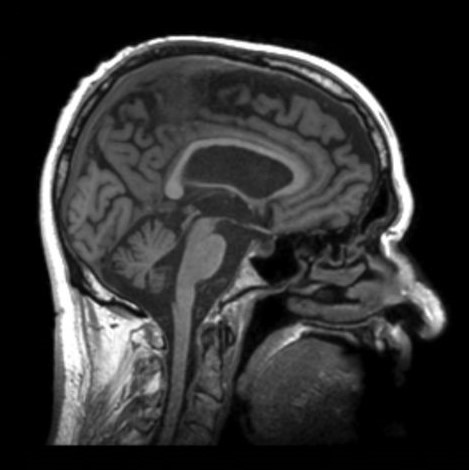

In [47]:
image,label=dataset[3000]
print(image.size)
print(label)
image


**Task**: create a `train_dataset` and `test_dataset` (without transforms for now).

In [61]:
# YOUR CODE HERE
from torch.utils.data import random_split
total_size=len(dataset)
train_size=int(0.7*total_size)
val_size=int(0.15*total_size)
test_size = total_size - train_size - val_size

print(f"train_size:{train_size},val_size:{val_size},test_size:{test_size}")
train_dataset, val_dataset, test_dataset=random_split(dataset,[train_size,val_size,test_size])
print(len(train_dataset))
print(len(val_dataset))
print(len(test_dataset))

train_size:4916,val_size:1053,test_size:1054
4916
1053
1054


**Quick Check**: verify the counts of both train and test sets, match what's in the original source (Kaggle).

In [62]:
# YOUR CODE HERE
if len(train_dataset)+len(val_dataset)+len(test_dataset)==7023:
  print(" matched with original source")
else:
  print("incorrect length")

 matched with original source


<a name='2'></a>
## 2. Data Preparation

Before training, we need to:
1. Define augmentation for training
2. Define normalization for both training and testing
3. Create **`DataLoader`** for efficient batch processing

**Task:** Create transformation pipelines for training and validation. Pre-trained models expect ImageNet normalization statistics.

**Reference:**

- [torchvision.transforms](https://pytorch.org/vision/stable/transforms.html)

In [64]:
# YOUR CODE HERE
from torchvision import transforms
#image resizing and normalization
#data augmentation (rotation, flipping, zooming)

train_transforms=transforms.Compose([transforms.Resize((224,224)),
                                     transforms.RandomRotation(10),
                                     transforms.RandomHorizontalFlip(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
                                     ])
val_transforms=transforms.Compose([transforms.Resize((224,224)),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
                                  ])




In [67]:
# apply transforms
from torch.utils.data import Dataset

class ApplyTransform(Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

In [68]:
train_dataset=ApplyTransform(train_dataset,train_transforms)
val_dataset=ApplyTransform(val_dataset,val_transforms)
test_dataset=ApplyTransform(test_dataset,val_transforms)

In [103]:
# YOUR CODE HERE
from torch.utils.data import DataLoader
num_cpu_cores = os.cpu_count()
train_dataloader=DataLoader(train_dataset,batch_size=512,shuffle=True,num_workers=num_cpu_cores)
val_dataloader=DataLoader(val_dataset,batch_size=512,shuffle=False,num_workers=num_cpu_cores)
test_dataloader=DataLoader(test_dataset,batch_size=512,shuffle=False,num_workers=num_cpu_cores)

**Quick Check**: Visualize a batch of training images

In [70]:
helper_utils.visualize_batch?

Object `helper_utils.visualize_batch` not found.


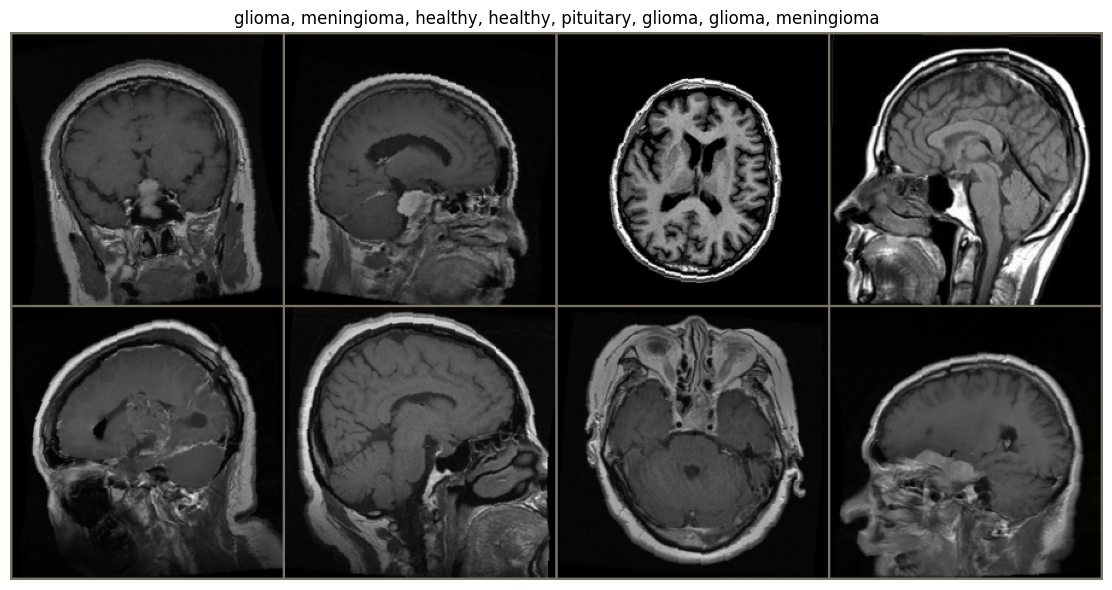

In [77]:
# YOUR CODE HERE
import helper_utils
import matplotlib.pyplot as plt
class_names=['pituitary', 'healthy', 'meningioma', 'glioma']
helper_utils.visualize_batch(train_dataloader,class_names)
plt.show()

In [104]:
# cheack loaders info
print(f"train_dataloader:{len(train_dataloader)}")
print(f"val_dataloader:{len(val_dataloader)}")
print(f"test_dataloader:{len(test_dataloader)}")
# shape of loaders
print(f"train_dataloader shape:{next(iter(train_dataloader))[0].shape}")
print(f"val_dataloader shape:{next(iter(val_dataloader))[0].shape}")
print(f"test_dataloader shape:{next(iter(test_dataloader))[0].shape}")

train_dataloader:10
val_dataloader:3
test_dataloader:3
train_dataloader shape:torch.Size([512, 3, 224, 224])
val_dataloader shape:torch.Size([512, 3, 224, 224])
test_dataloader shape:torch.Size([512, 3, 224, 224])


<a name='3'></a>
## 3. Model Building

We'll use a pre-trained ResNet-18 model and adapt it for our 6-class classification task.

**Task:** Load a pre-trained ResNet-18 model and modify the final layer for 6 classes.

**Reference:**

- [PyTorch Transfer Learning Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- [torchvision.models](https://pytorch.org/vision/stable/models.html)
- [ResNet documentation](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html)

<a name='4'></a>
## 4. Training

**Task:** Implement a training **function** and then train using two different transfer learning strategies.

**Reference:** [PyTorch Training Tutorial](https://docs.pytorch.org/tutorials/beginner/introyt/trainingyt.html#the-training-loop)

In [107]:
# implement full training loop
from tqdm import tqdm
def train_epoch(model, dataloader, loss_fn, optimizer, device):
  model.train()
  running_loss=0.0
  running_corrects=0
  for inputs,labels in dataloader:
    inputs=inputs.to(device)
    labels=labels.to(device)
    optimizer.zero_grad()

    outputs=model(inputs)
    _,preds=torch.max(outputs,1)
    loss=loss_fn(outputs,labels)
    loss.backward()
    optimizer.step()

    running_loss+=loss.item()*inputs.size(0)
    running_corrects+=torch.sum(preds==labels.data)
  return running_loss/len(dataloader.dataset),running_corrects.double()/len(dataloader.dataset)

def test_val_epoch(model, dataloader, loss_fn, device):
  model.eval()
  running_loss=0.0
  running_corrects=0
  for inputs,labels in dataloader:
    inputs=inputs.to(device)
    labels=labels.to(device)
    with torch.no_grad():
      outputs=model(inputs)
      _,preds=torch.max(outputs,1)
      loss=loss_fn(outputs,labels)
      running_loss+=loss.item()*inputs.size(0)
      running_corrects+=torch.sum(preds==labels.data)
  return running_loss/len(dataloader.dataset),running_corrects.double()/len(dataloader.dataset)


<a name='4-1'></a>
### 4.1 ConvNet as Fixed Feature Extractor

In this approach, we freeze all the convolutional layers and only train the final classifier layer.

**Task:**

1. Load a fresh pre-trained model
2. Freeze all parameters except the final layer
3. Set up optimizer to only train the final layer
4. Train the model

In [105]:
# YOUR CODE HERE
from torchvision import models
model=models.resnet18(pretrained=True)

# freez the weights of the entire all lyers expect fc
for param in model.parameters():
  param.requires_grad=False


model.fc=nn.Linear(model.fc.in_features,4)
# Verification
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable layer: {name}")
model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Trainable layer: fc.weight
Trainable layer: fc.bias


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [106]:
# YOUR CODE HERE
from torch import optim
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [108]:
# train 100 epoch
epoch=100
train_loss=[]
train_acc=[]
val_loss=[]
val_acc=[]
for i in range(epoch):
  loss,acc=train_epoch(model,train_dataloader,criterion,optimizer,device)
  train_loss.append(loss)
  train_acc.append(acc)
  loss,acc=test_val_epoch(model,val_dataloader,criterion,device)
  val_loss.append(loss)
  val_acc.append(acc)
  print(f"epoch:{i+1}/{epoch},train_loss:{train_loss[i]:.4f},train_acc:{train_acc[i]:.4f},val_loss:{val_loss[i]:.4f},val_acc:{val_acc[i]:.4f}")

epoch:1/100,train_loss:1.3021,train_acc:0.3983,val_loss:1.1969,val_acc:0.5005
epoch:2/100,train_loss:0.9298,train_acc:0.7144,val_loss:0.9525,val_acc:0.6572
epoch:3/100,train_loss:0.7288,train_acc:0.7832,val_loss:0.8178,val_acc:0.6990
epoch:4/100,train_loss:0.6179,train_acc:0.8118,val_loss:0.7061,val_acc:0.7398
epoch:5/100,train_loss:0.5520,train_acc:0.8306,val_loss:0.6242,val_acc:0.7816
epoch:6/100,train_loss:0.5085,train_acc:0.8399,val_loss:0.5616,val_acc:0.7939
epoch:7/100,train_loss:0.4793,train_acc:0.8440,val_loss:0.5182,val_acc:0.8158
epoch:8/100,train_loss:0.4573,train_acc:0.8511,val_loss:0.4933,val_acc:0.8253
epoch:9/100,train_loss:0.4421,train_acc:0.8537,val_loss:0.4674,val_acc:0.8433
epoch:10/100,train_loss:0.4206,train_acc:0.8552,val_loss:0.4550,val_acc:0.8433
epoch:11/100,train_loss:0.4069,train_acc:0.8625,val_loss:0.4433,val_acc:0.8462
epoch:12/100,train_loss:0.3988,train_acc:0.8603,val_loss:0.4310,val_acc:0.8519
epoch:13/100,train_loss:0.3921,train_acc:0.8657,val_loss:0.42

In [109]:
# test
loss,acc=test_val_epoch(model,test_dataloader,criterion,device)
print(f"test_loss:{loss:.4f},test_acc:{acc:.4f}")

test_loss:0.2559,test_acc:0.9042


**Quick Check**: Visualize training history

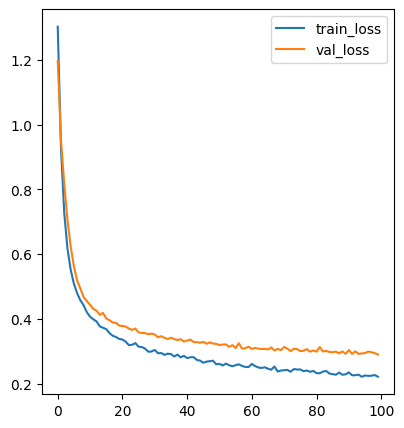

In [110]:
# plot epochs loss and acc for
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_loss,label="train_loss")
plt.plot(val_loss,label="val_loss")
plt.legend()

**Quick Check**: Visualize predictions

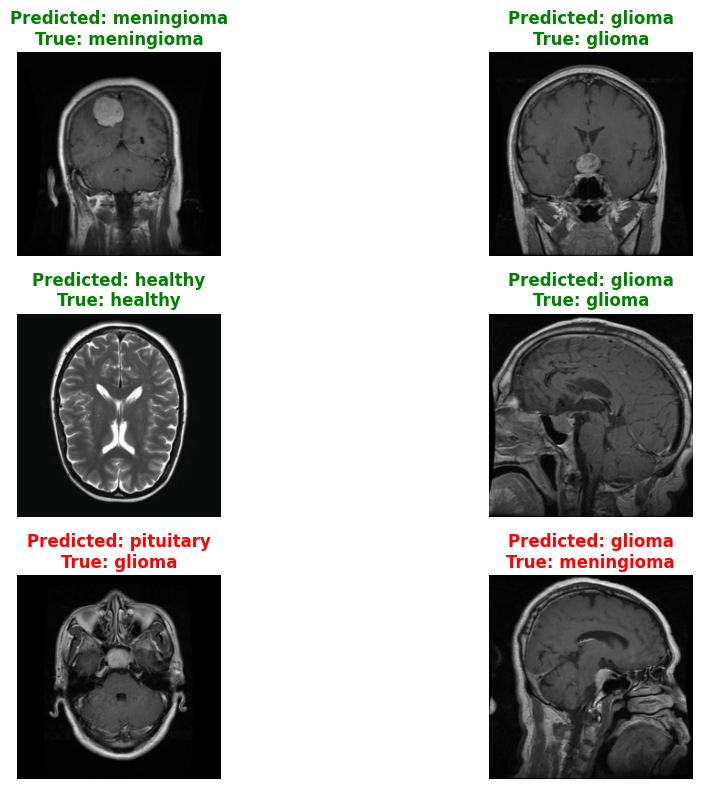

In [113]:
helper_utils.visualize_predictions(model, val_dataloader, class_names, device, num_images=6)
plt.show()

<a name='4-2'></a>
### 4.2 Fine-tuning the ConvNet

In this approach, we unfreeze all layers and train the entire network with a smaller learning rate.

**Task:**

1. Load a fresh pre-trained model
2. Modify the final layer
3. Set up optimizer for all parameters with a smaller learning rate
4. Train the model

In [114]:
# YOUR CODE HERE
from torchvision import models
model=models.resnet18(pretrained=True)

model.fc=nn.Linear(model.fc.in_features,4)
# Verification
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable layer: {name}")
model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Trainable layer: conv1.weight
Trainable layer: bn1.weight
Trainable layer: bn1.bias
Trainable layer: layer1.0.conv1.weight
Trainable layer: layer1.0.bn1.weight
Trainable layer: layer1.0.bn1.bias
Trainable layer: layer1.0.conv2.weight
Trainable layer: layer1.0.bn2.weight
Trainable layer: layer1.0.bn2.bias
Trainable layer: layer1.1.conv1.weight
Trainable layer: layer1.1.bn1.weight
Trainable layer: layer1.1.bn1.bias
Trainable layer: layer1.1.conv2.weight
Trainable layer: layer1.1.bn2.weight
Trainable layer: layer1.1.bn2.bias
Trainable layer: layer2.0.conv1.weight
Trainable layer: layer2.0.bn1.weight
Trainable layer: layer2.0.bn1.bias
Trainable layer: layer2.0.conv2.weight
Trainable layer: layer2.0.bn2.weight
Trainable layer: layer2.0.bn2.bias
Trainable layer: layer2.0.downsample.0.weight
Trainable layer: layer2.0.downsample.1.weight
Trainable layer: layer2.0.downsample.1.bias
Trainable layer: layer2.1.conv1.weight
Trainable layer: layer2.1.bn1.weight
Trainable layer: layer2.1.bn1.bias
Tra

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [115]:
# YOUR CODE HERE
from torch import optim
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=0.001)

In [116]:
# train 100 epoch
epoch=100
train_loss=[]
train_acc=[]
val_loss=[]
val_acc=[]
for i in range(epoch):
  loss,acc=train_epoch(model,train_dataloader,criterion,optimizer,device)
  train_loss.append(loss)
  train_acc.append(acc)
  loss,acc=test_val_epoch(model,val_dataloader,criterion,device)
  val_loss.append(loss)
  val_acc.append(acc)
  print(f"epoch:{i+1}/{epoch},train_loss:{train_loss[i]:.4f},train_acc:{train_acc[i]:.4f},val_loss:{val_loss[i]:.4f},val_acc:{val_acc[i]:.4f}")

epoch:1/100,train_loss:0.4703,train_acc:0.8076,val_loss:2.7306,val_acc:0.7151
epoch:2/100,train_loss:0.1253,train_acc:0.9561,val_loss:0.3852,val_acc:0.9031
epoch:3/100,train_loss:0.0614,train_acc:0.9790,val_loss:0.2649,val_acc:0.9231
epoch:4/100,train_loss:0.0366,train_acc:0.9876,val_loss:0.2046,val_acc:0.9392
epoch:5/100,train_loss:0.0198,train_acc:0.9941,val_loss:0.0725,val_acc:0.9649
epoch:6/100,train_loss:0.0154,train_acc:0.9949,val_loss:0.2333,val_acc:0.9269
epoch:7/100,train_loss:0.0130,train_acc:0.9959,val_loss:0.1218,val_acc:0.9668
epoch:8/100,train_loss:0.0096,train_acc:0.9969,val_loss:0.1306,val_acc:0.9630
epoch:9/100,train_loss:0.0128,train_acc:0.9951,val_loss:0.0437,val_acc:0.9858
epoch:10/100,train_loss:0.0073,train_acc:0.9980,val_loss:0.1835,val_acc:0.9440
epoch:11/100,train_loss:0.0120,train_acc:0.9959,val_loss:0.1852,val_acc:0.9563
epoch:12/100,train_loss:0.0216,train_acc:0.9917,val_loss:0.2501,val_acc:0.9326
epoch:13/100,train_loss:0.0172,train_acc:0.9939,val_loss:0.16

In [117]:
# test
loss,acc=test_val_epoch(model,test_dataloader,criterion,device)
print(f"test_loss:{loss:.4f},test_acc:{acc:.4f}")

test_loss:0.0351,test_acc:0.9943


**Quick Check**: Visualize training history

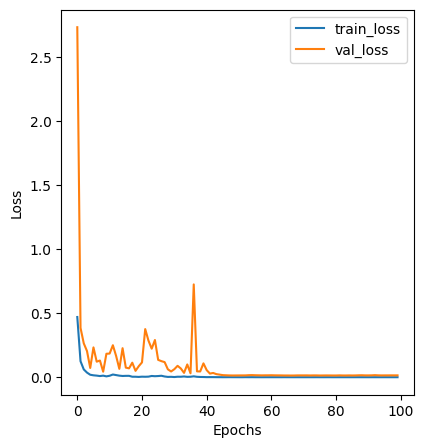

In [118]:
# plot epochs loss and acc for
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(train_loss,label="train_loss")
plt.plot(val_loss,label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

**Quick Check**: Visualize predictions

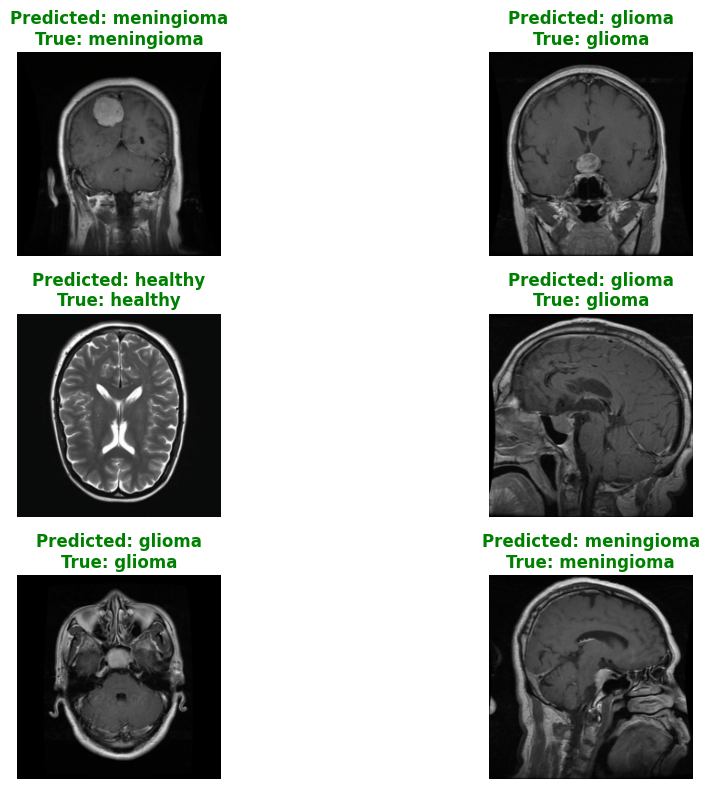

In [119]:
helper_utils.visualize_predictions(model, val_dataloader, class_names, device, num_images=6)
plt.show()

<a name='5'></a>
## 5. Evaluation

Compare the performance of both approaches.

**Task:** Evaluate both models and compare their performance metrics.

full fine tune preform better due to the limitation of the single fc layer in freezed version of resnet model

<a name='6'></a>
## 6. Inference on Custom Images

Test your trained model on custom images.

**Task:** Load a custom image, preprocess it, and make a prediction using your trained model.

**Reference:** [Image Preprocessing](https://pytorch.org/vision/stable/transforms.html)

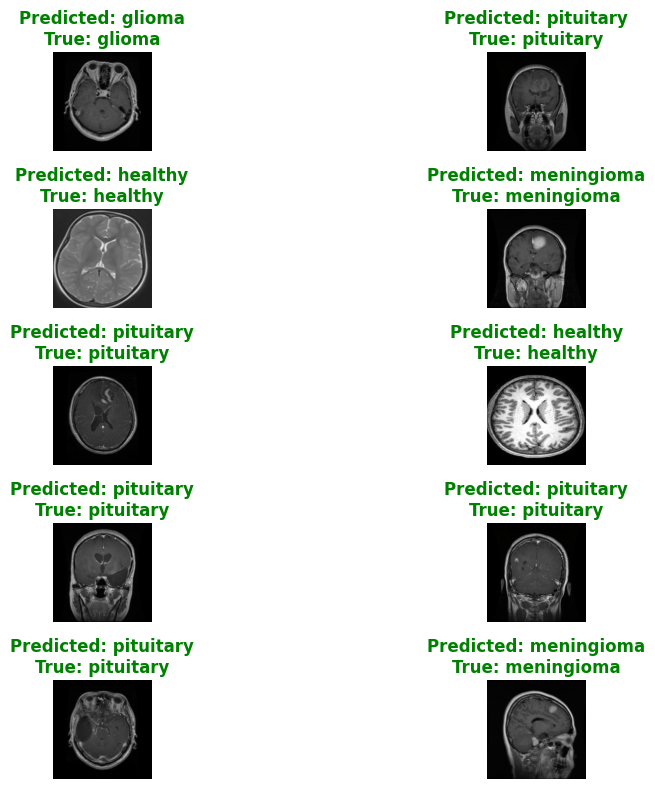

In [120]:
helper_utils.visualize_predictions(model, test_dataloader, class_names, device, num_images=10)
plt.show()

# 🏆🎉 Congratulations on completing the Weekly Final Project! 🎉🏆

Fantastic job on finishing the Weekly Final Project! You’ve put your skills to the test and made it to the end. Take a moment to celebrate your hard work and dedication. Keep up the great work and continue your learning journey!

<a name='7'></a>
## 7. Deployment (ONNX)

Convert your trained model to ONNX format for deployment.

**Task:**
1. Convert the PyTorch model to ONNX format
2. Load the ONNX model and perform inference

**Reference:**
- [PyTorch to ONNX](https://docs.pytorch.org/tutorials/beginner/onnx/export_simple_model_to_onnx_tutorial.html)

In [137]:
# Install the version with GPU support for your A100
!pip install onnxruntime-gpu


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 300.5/300.5 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 10.0 MB/s eta 0:00:00


In [126]:
# Convert model to ONNX
# YOUR CODE HERE
import torch.onnx as onnx
# Set model to evaluation mode
model.eval()

# Create dummy input (batch_size=1, channels=3, height=224, width=224)
dummy_input = torch.randn(1, 3, 224, 224).to(device)

# Export to ONNX
onnx_path = 'model.onnx'
torch.onnx.export(
     model,
     dummy_input,
     onnx_path,
 )
print(f"Model exported to {onnx_path}")

[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`...
[torch.onnx] Obtain model graph for `ResNet([...]` with `torch.export.export(..., strict=False)`... ✅
[torch.onnx] Run decomposition...
[torch.onnx] Run decomposition... ✅
[torch.onnx] Translate the graph into ONNX...
[torch.onnx] Translate the graph into ONNX... ✅
Applied 40 of general pattern rewrite rules.
Model exported to model.onnx


In [132]:
# get one element from test loader batch
inputs,labels=next(iter(test_dataloader))
input=inputs[0].size()
label=labels[0]
print(input)
print(label)

torch.Size([3, 224, 224])
tensor(3)


In [169]:
# Load ONNX model and perform inference
# YOUR CODE HERE
import onnxruntime as ort
import numpy as np
from scipy.special import softmax


test_dataloader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=0  # Set to 0 to avoid the segmentation fault
)
# Load ONNX model
ort_session = ort.InferenceSession(onnx_path)

# Prepare input (use validation transform)
#img_path = 'path/to/test/image.jpg'
# img = Image.open(img_path).convert('RGB')
inputs,labels=next(iter(test_dataloader))
input=inputs[16]
label=labels[16]
img_tensor = input.unsqueeze(0)
img_numpy = img_tensor.numpy()

# Run inference
outputs = ort_session.run(None, {'x': img_numpy})
predictions = np.array(outputs[0])
pred_class_idx = np.argmax(predictions[0])
pred_class = class_names[pred_class_idx]
probabilities = softmax(outputs[0])
pred_class_idx = np.argmax(probabilities)
pred_class = class_names[pred_class_idx]
confidence = probabilities[0][pred_class_idx]

print(f"Predicted: {pred_class} (Confidence: {confidence * 100:.2f}%)")


Predicted: healthy (Confidence: 100.00%)
